In [25]:
import random
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, notebook
import os
import time
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.resnet import ResNet50, preprocess_input
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [26]:
from keras.utils import image_utils

model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image_utils.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image_utils.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [27]:
#features = extract_features('./ump_data/sample_images/cat.jpg', model)
#print(len(features))

In [28]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

# path to the datasets
root_dir = './ump_data/test_img'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in notebook.tqdm(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


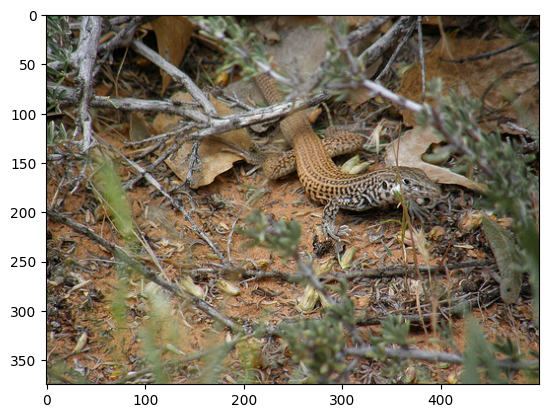

In [29]:
#Similarity Search
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Show the plots as a cell within the Jupyter Notebooks
%matplotlib inline       
plt.imshow(mpimg.imread(filenames[0]))

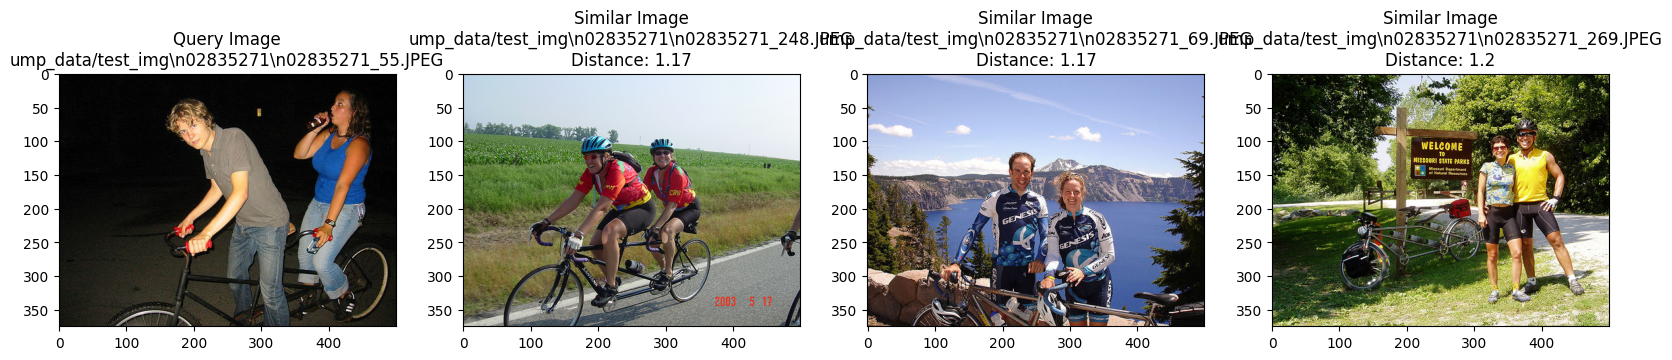

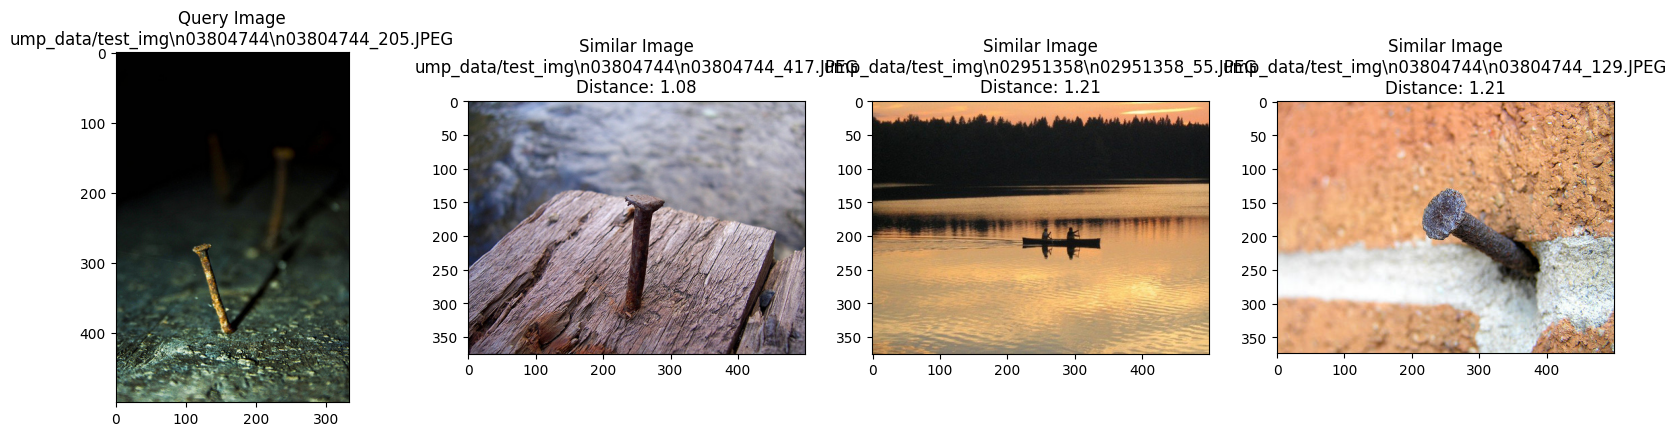

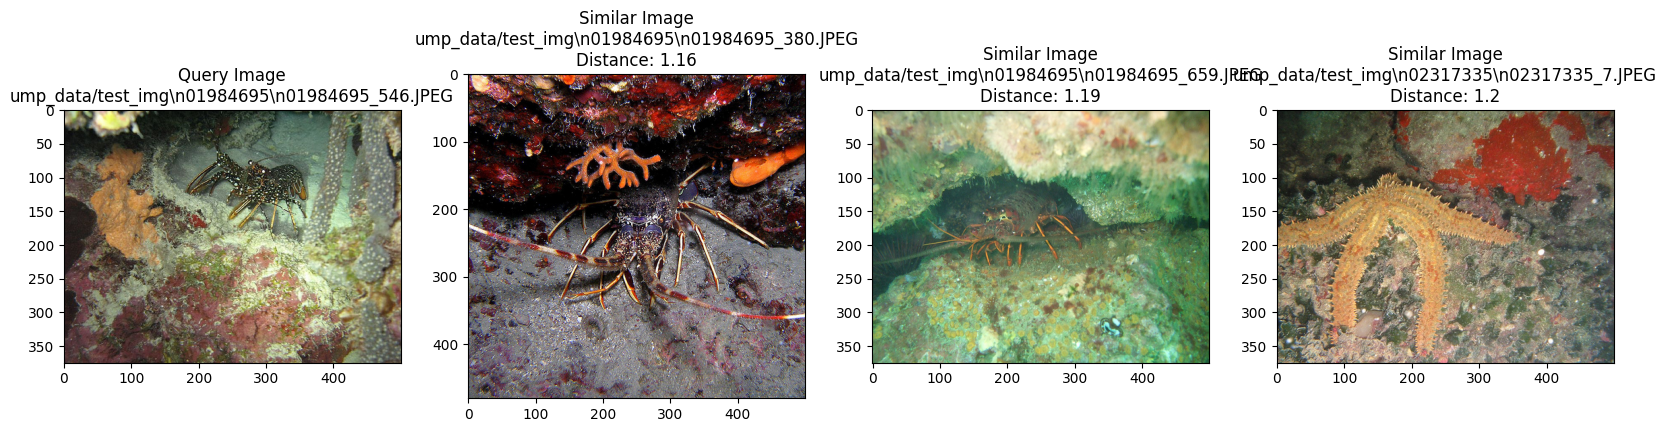

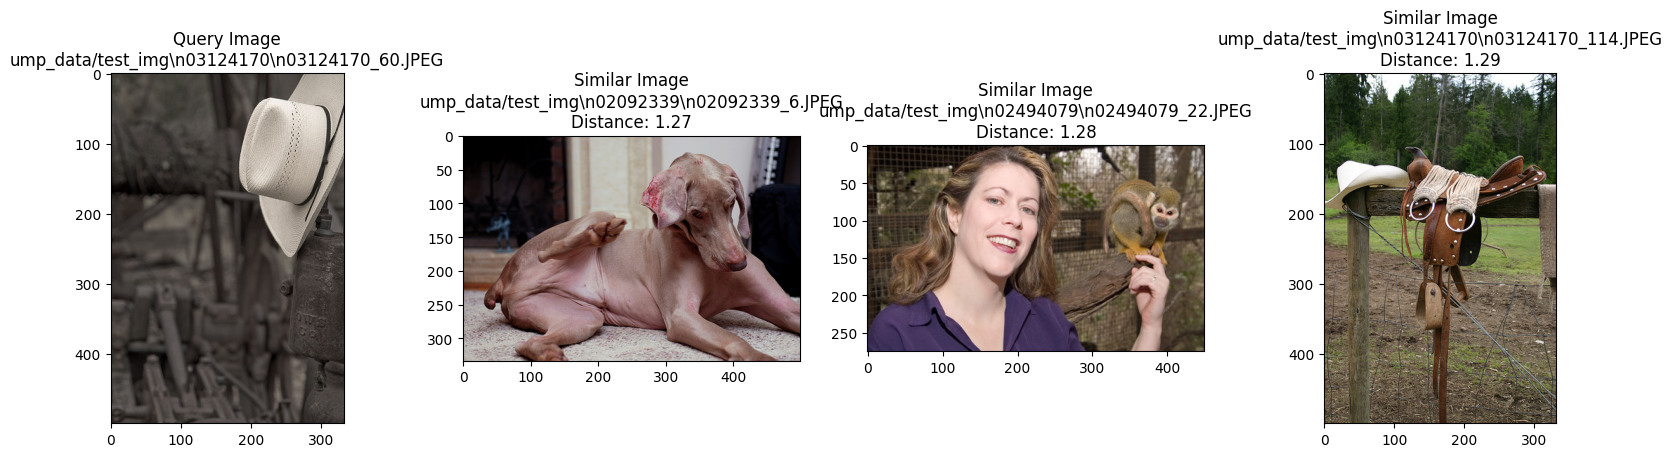

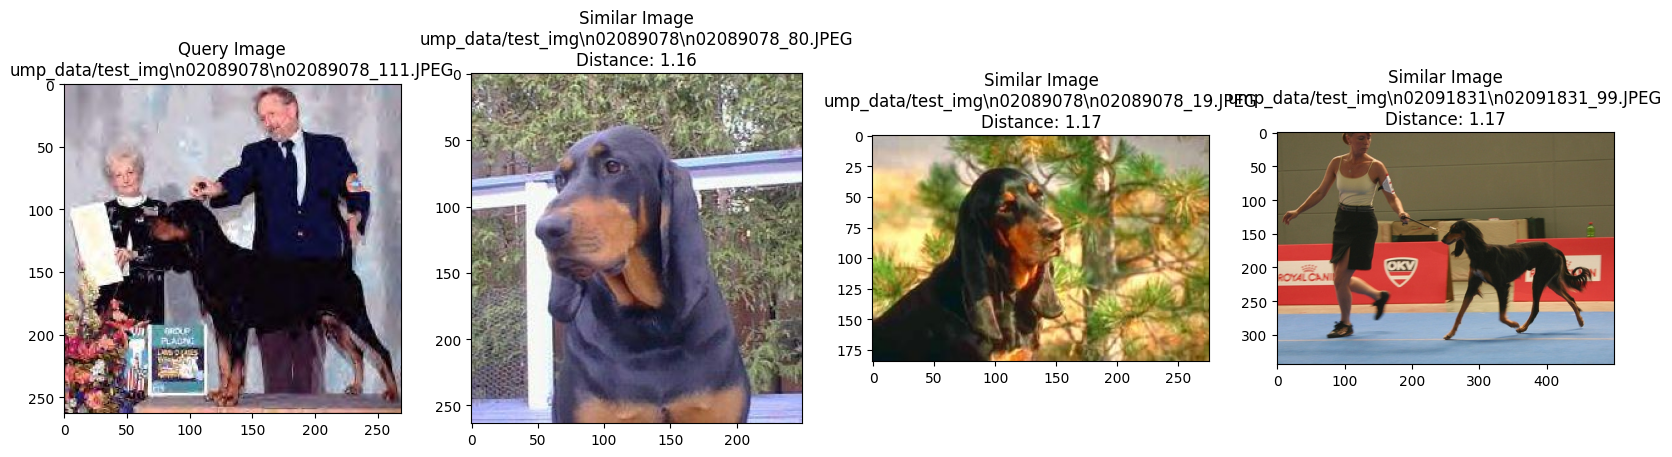

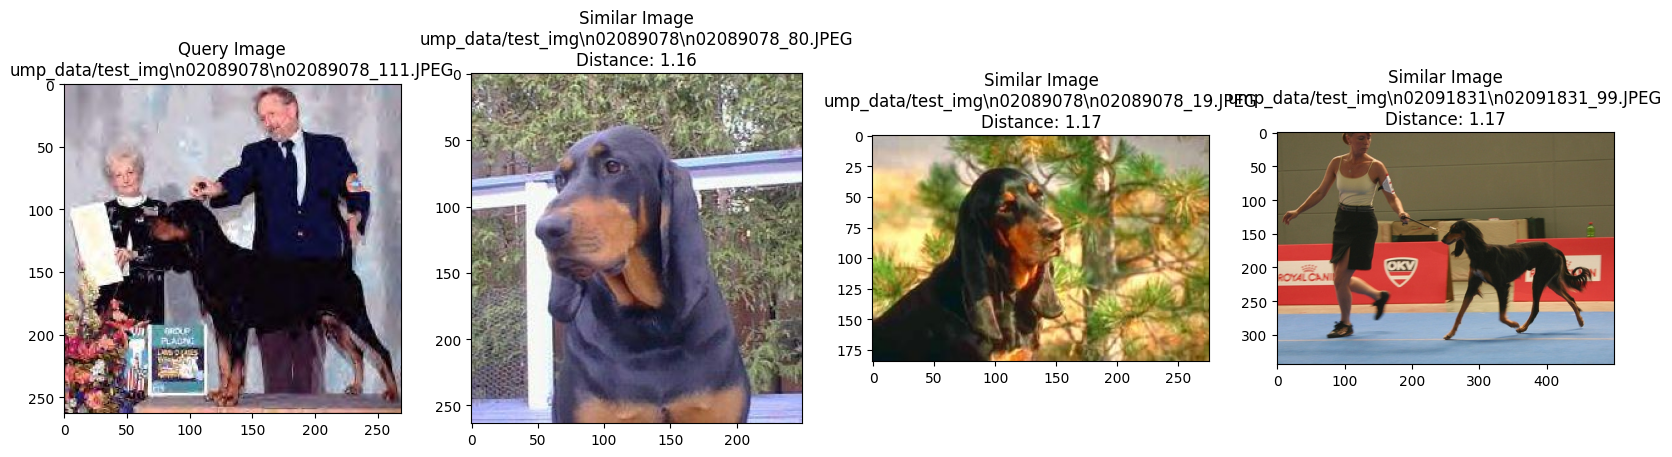

In [30]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]

# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(round(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        
num_images = 300
for i in range(6):
    random_image_index = random.randint(0,num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    # don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
    plot_images(similar_image_paths, distances[0])



Found 300 images belonging to 30 classes.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.331356
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.971962
[t-SNE] KL divergence after 1000 iterations: 0.691892


C:\Users\yuanh\AppData\Local\Temp\ipykernel_10568\2281638409.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')


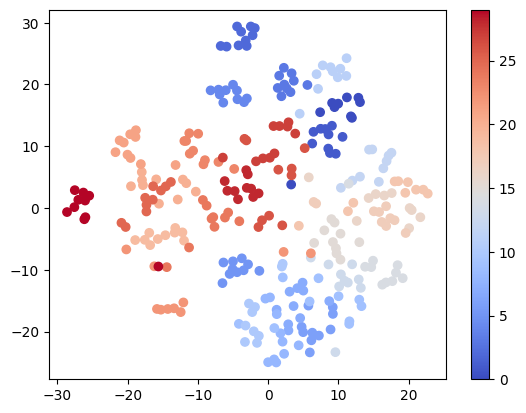

In [31]:
#Visualizing Image Clusters with t-SNE

# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

#create class_idsv from datagen.flow_from_directory

batch_size = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False)
class_ids = generator.classes

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:]
selected_class_ids = class_ids[:]
selected_filenames = filenames[:]

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c =selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()